In [128]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

Wczytanie danych z czujników IMU, prędkości po filtracji oraz pozycji GNSS. Obliczenie współczynników przeliczeniowych stopni geograficznych na metry.

In [129]:
df_imu = pd.read_csv('imu_data.csv')
df_vel = pd.read_csv('filter_velocity.csv')
df_pose = pd.read_csv('gnss_pose.csv')

df_imu = df_imu.sort_values('time')
df_vel = df_vel.sort_values('time')
df_pose = df_pose.sort_values('time')

METERS_PER_DEG_LAT = 111132.0

mean_lat = df_pose['pose.position.x'].mean()
METERS_PER_DEG_LON = 111132.0 * np.cos(np.radians(mean_lat))

print(f"METERS_PER_DEG_LAT: {METERS_PER_DEG_LAT}\nMETERS_PER_DEG_LON: {METERS_PER_DEG_LON}")

METERS_PER_DEG_LAT: 111132.0
METERS_PER_DEG_LON: 71386.11581149495


### IMU quaternions to Euler 

Przekształcenie orientacji z postaci kwaternionów do kątów Eulera (roll, pitch) oraz wyznaczenie całkowitego przyspieszenia na podstawie składowych z akcelerometru.

In [130]:
quants = df_imu[['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w']].values

r = R.from_quat(quants)
euler = r.as_euler('xyz', degrees=True)

df_imu['roll'] = np.abs(euler[:, 0])

df_imu['turn_rate'] = df_imu['angular_velocity.z'].abs()

df_imu['acc_total'] = np.sqrt(
    df_imu['linear_acceleration.x']**2 +
    df_imu['linear_acceleration.y']**2 +
    df_imu['linear_acceleration.z']**2
)

df_imu['vibration_energy'] = df_imu['acc_total'].rolling(window=25, center=False).std()
df_imu['vibration_energy'] = df_imu['vibration_energy'].fillna(0)


print(f"shape: {df_imu.shape}")
df_imu.head(2)

shape: (2916, 18)


,time,orientation.x,orientation.y,orientation.z,orientation.w,orientation_covariance,angular_velocity.x,angular_velocity.y,angular_velocity.z,angular_velocity_covariance,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,linear_acceleration_covariance,roll,turn_rate,acc_total,vibration_energy
0,1.354145,-0.002686,-0.00406,0.975792,0.218647,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.164361,-0.017460,-0.099404,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.300894,-0.180785,9.659451,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.521309,0.099404,9.665827,0.0
1,1.374145,-0.002217,-0.00253,0.975581,0.219617,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.149255,-0.016467,-0.102909,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.526813,-0.065190,9.931564,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.338681,0.102909,9.945740,0.0


### Velocity & GNSS fusion

Obliczenie modułu wektora prędkości filtrowanej oraz estymacja prędkości na podstawie danych GNSS z wykorzystaniem przyrostów pozycji i czasu.


In [131]:
df_vel['speed_filter'] = np.sqrt(df_vel['vector.x']**2 + df_vel['vector.y']**2 + df_vel['vector.z']**2)

df_pose['dt'] = df_pose['time'].diff()

d_lat_m = df_pose['pose.position.x'].diff() * METERS_PER_DEG_LAT
d_lon_m = df_pose['pose.position.y'].diff() * METERS_PER_DEG_LON

df_pose['dist'] = np.sqrt(d_lat_m**2 + d_lon_m**2)

df_pose['speed_gps'] = df_pose['dist'] / df_pose['dt']
df_pose['speed_gps'] = df_pose['speed_gps'].fillna(0)

print(f"shape: {df_pose.shape}")
df_pose.head(5)


shape: (2912, 11)


,time,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w,dt,dist,speed_gps
0,1.434146,50.032473,19.995206,237.308843,-0.000907,0.001389,0.974938,0.222472,NaN,NaN,0.000000
1,1.454146,50.032473,19.995206,237.308914,-0.000508,0.002433,0.974725,0.223394,0.02,0.003014,0.150695
2,1.474146,50.032473,19.995206,237.308942,-0.000156,0.003312,0.974515,0.224298,0.02,0.003026,0.151321
3,1.494146,50.032473,19.995206,237.308926,0.000150,0.004017,0.974305,0.225196,0.02,0.003025,0.151234
4,1.514146,50.032473,19.995206,237.308888,0.000444,0.004515,0.974097,0.226086,0.02,0.003052,0.152599


### Data merge

Synchronizacja danych z IMU, prędkości filtrowanej oraz GNSS na podstawie znacznika czasu z wykorzystaniem metody najbliższej próbki, a następnie obliczenie bezwzględnej różnicy pomiędzy prędkością filtrowaną a prędkością GNSS jako miary ich niespójności.

In [132]:
df_merged = pd.merge_asof(
    df_imu,
    df_vel[['time', 'speed_filter']],
    on='time',
    direction='backward', 
    tolerance=0.1
)

df_merged = pd.merge_asof(
    df_merged,
    df_pose[['time', 'speed_gps']],
    on='time',
    direction='backward',
    tolerance=0.2
)

df_merged = df_merged.dropna()

In [133]:
df_merged['speed_mismatch'] = (df_merged['speed_filter'] - df_merged['speed_gps']).abs()

print(f"shape: {df_merged.shape}")
df_merged.head(100)


shape: (2912, 21)


,time,orientation.x,orientation.y,orientation.z,orientation.w,orientation_covariance,angular_velocity.x,angular_velocity.y,angular_velocity.z,angular_velocity_covariance,...,linear_acceleration.y,linear_acceleration.z,linear_acceleration_covariance,roll,turn_rate,acc_total,vibration_energy,speed_filter,speed_gps,speed_mismatch
4,1.434146,-0.000907,0.001389,0.974938,0.222472,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.112689,-0.005093,-0.097610,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.093275,9.685590,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.132112,0.097610,9.688455,0.000000,0.042382,0.000000,0.042382
5,1.454146,-0.000508,0.002433,0.974725,0.223394,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.108669,-0.014444,-0.094597,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.024857,9.834885,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.258695,0.094597,9.836037,0.000000,0.041999,0.150695,0.108696
6,1.474146,-0.000156,0.003312,0.974515,0.224298,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.089589,-0.013655,-0.093943,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.028812,9.741920,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.365810,0.093943,9.741966,0.000000,0.043124,0.151321,0.108197
7,1.494146,0.000150,0.004017,0.974305,0.225196,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.062752,-0.019480,-0.095525,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.205307,9.690042,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.452319,0.095525,9.692365,0.000000,0.044710,0.151234,0.106523
8,1.514146,0.000444,0.004515,0.974097,0.226086,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.048510,-0.020108,-0.091155,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.186734,9.701994,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.515468,0.091155,9.703804,0.000000,0.045928,0.152599,0.106671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,3.334144,-0.004861,-0.003795,0.968478,0.249024,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.041325,-0.042935,0.203382,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.269595,9.672042,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.559898,0.203382,9.686513,0.114436,0.585162,0.539372,0.045790
100,3.354144,-0.004393,-0.003486,0.968989,0.247041,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.031929,-0.036144,0.207432,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.384201,9.692196,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.511398,0.207432,9.700735,0.116244,0.593985,0.547613,0.046372
101,3.374144,-0.003981,-0.003223,0.969509,0.245002,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.034335,-0.025980,0.216618,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.431842,9.600476,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.469803,0.216618,9.614037,0.125683,0.602709,0.556701,0.046008
102,3.394144,-0.003572,-0.002975,0.970039,0.242905,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.031985,-0.032918,0.223131,[0. 0. 0. 0. 0. 0. 0. 0. 0.],...,0.378727,9.620100,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.430140,0.223131,9.628837,0.131525,0.611229,0.566105,0.045125


### Data discretization

Dyskretyzacja cech opisujących orientację, niespójność prędkości oraz drgania do postaci stanów jakościowych na potrzeby sieci bayesowskiej.

Ciągłe zmienne pomiarowe zostały zdyskretyzowane do trzech stanów: *Low*, *Medium* oraz *High*.

- **Roll**: wartości kąta są bardzo małe (rzędu ~0.5°), dlatego przyjęto czułe progi lub interpretację niskich wartości jako stan bezpieczny  
  (< 5° – Low, 5–15° – Medium, > 15° – High).

- **Speed mismatch**: różnica pomiędzy prędkością filtrowaną a GNSS wynosi typowo ~0.01 m/s, z okazjonalnymi skokami do ~0.1 m/s.  
  Próg ostrzegawczy ustawiono na 0.2 m/s w celu ograniczenia wpływu szumu pomiarowego.

- **Vibration**: miara drgań została wyznaczona jako odchylenie całkowitego przyspieszenia od wartości grawitacji (9.81 m/s²).


In [134]:
df_bn = pd.DataFrame()

df_bn['Roll_State'] = pd.cut(df_merged['roll'], 
                             bins=[-1, 2, 10, 180], 
                             labels=[0, 1, 2]).astype(int)

df_bn['Mismatch_State'] = pd.cut(df_merged['speed_mismatch'], 
                                 bins=[-1, 0.2, 0.5, 100], 
                                 labels=[0, 1, 2]).astype(int)

df_bn['Vibration_State'] = pd.cut(df_merged['vibration_energy'], 
                                  bins=[-1, 0.15, 0.5, 100], 
                                  labels=[0, 1, 2]).astype(int)

df_bn['Turn_State'] = pd.cut(df_merged['turn_rate'], 
                             bins=[-1, 0.1, 0.3, 100], 
                             labels=[0, 1, 2]).astype(int)

df_bn['Engine_Status'] = pd.cut(df_merged['speed_filter'], 
                                bins=[-1, 0.2, 100], 
                                labels=[0, 1]).astype(int)

print(df_bn.head(10))

    Roll_State  Mismatch_State  Vibration_State  Turn_State  Engine_Status
4            0               0                0           0              0
5            0               0                0           0              0
6            0               0                0           0              0
7            0               0                0           0              0
8            0               0                0           0              0
9            0               0                0           0              0
10           0               0                0           0              0
11           0               0                0           0              0
12           0               0                0           0              0
13           0               0                0           1              0


In [135]:
print("\nLiczba wystąpień każdego stanu:")
print(df_bn['Roll_State'].value_counts(), '\n')
print(df_bn['Mismatch_State'].value_counts(), '\n')
print(df_bn['Vibration_State'].value_counts(), '\n')
print(df_bn['Turn_State'].value_counts(), '\n')
print(df_bn['Engine_Status'].value_counts())


Liczba wystąpień każdego stanu:
Roll_State
0    2830
1      82
Name: count, dtype: int64 

Mismatch_State
0    2567
1     333
2      12
Name: count, dtype: int64 

Vibration_State
1    1459
0    1330
2     123
Name: count, dtype: int64 

Turn_State
0    1088
1     937
2     887
Name: count, dtype: int64 

Engine_Status
1    2664
0     248
Name: count, dtype: int64


Definicja struktury sieci opisującej zależności pomiędzy stanem morza, integralnością czujników i statusem systemu, zdefiniowanie tablic prawdopodobieństw warunkowych (CPD)

In [136]:
model = DiscreteBayesianNetwork([
    ('Sea_State', 'Roll_State'),
    ('Turn_State', 'Roll_State'),
    ('Sea_State', 'Vibration_State'),
    ('Engine_Status', 'Vibration_State'),
    ('Sensor_Integrity', 'Mismatch_State'),
    ('Sea_State', 'System_Status'),
    ('Sensor_Integrity', 'System_Status') 
])

cpd_sea = TabularCPD(variable='Sea_State', variable_card=2, values=[[0.90], [0.10]])

cpd_sensor = TabularCPD(variable='Sensor_Integrity', variable_card=2, values=[[0.95], [0.05]])

cpd_engine = TabularCPD(variable='Engine_Status', variable_card=2, values=[[0.5], [0.5]])

cpd_turn = TabularCPD(variable='Turn_State', variable_card=3, values=[[0.70], [0.20], [0.10]])

cpd_roll = TabularCPD(variable='Roll_State', variable_card=3, 
                      values=[
                          [0.98, 0.50, 0.10, 0.20, 0.10, 0.05], 
                          [0.02, 0.45, 0.60, 0.70, 0.60, 0.45], 
                          [0.00, 0.05, 0.30, 0.10, 0.30, 0.50]], 
                      evidence=['Sea_State', 'Turn_State'], evidence_card=[2, 3])

cpd_vib = TabularCPD(variable='Vibration_State', variable_card=3, 
                      values=[
                          [0.99, 0.20, 0.40, 0.05], 
                          [0.01, 0.75, 0.50, 0.60], 
                          [0.00, 0.05, 0.10, 0.35]], 
                      evidence=['Sea_State', 'Engine_Status'], evidence_card=[2, 2])

cpd_mismatch = TabularCPD(variable='Mismatch_State', variable_card=3, 
                      values=[
                          [0.95, 0.10], 
                          [0.04, 0.30], 
                          [0.01, 0.60]], 
                      evidence=['Sensor_Integrity'], evidence_card=[2])

cpd_status = TabularCPD(variable='System_Status', variable_card=3, 
                      values=[
                          [0.99, 0.20, 0.50, 0.00], 
                          [0.01, 0.50, 0.40, 0.20], 
                          [0.00, 0.30, 0.10, 0.80]], 
                      evidence=['Sea_State', 'Sensor_Integrity'], evidence_card=[2, 2])

model.add_cpds(cpd_sea, cpd_sensor,cpd_engine,cpd_turn, cpd_roll, cpd_vib, cpd_mismatch, cpd_status)

assert model.check_model()

infer = VariableElimination(model)

Wnioskowanie dla wybranych scenariuszy obserwacji.

In [137]:
q = infer.query(variables=['System_Status'], 
                evidence={
                    'Mismatch_State': 2, 
                    'Roll_State': 0,
                    'Vibration_State': 1,
                    'Turn_State': 0,
                    'Engine_Status': 1
                    })
print(q)

q_safe = infer.query(variables=['System_Status'], 
                     evidence={
                    'Mismatch_State': 0, 
                    'Roll_State': 0,
                    'Vibration_State': 0,
                    'Turn_State': 0,
                    'Engine_Status': 0
                    })
print(q_safe)

+------------------+----------------------+
| System_Status    |   phi(System_Status) |
+==================+======================+
| System_Status(0) |               0.3852 |
+------------------+----------------------+
| System_Status(1) |               0.3798 |
+------------------+----------------------+
| System_Status(2) |               0.2350 |
+------------------+----------------------+
+------------------+----------------------+
| System_Status    |   phi(System_Status) |
+==================+======================+
| System_Status(0) |               0.9812 |
+------------------+----------------------+
| System_Status(1) |               0.0162 |
+------------------+----------------------+
| System_Status(2) |               0.0026 |
+------------------+----------------------+


Dyskretyzacja danych pomiarowych do postaci numerycznej, przeprowadzenie wnioskowania probabilistycznego dla każdej próbki czasowej oraz analiza zmian prawdopodobieństw stanów systemu w funkcji czasu.

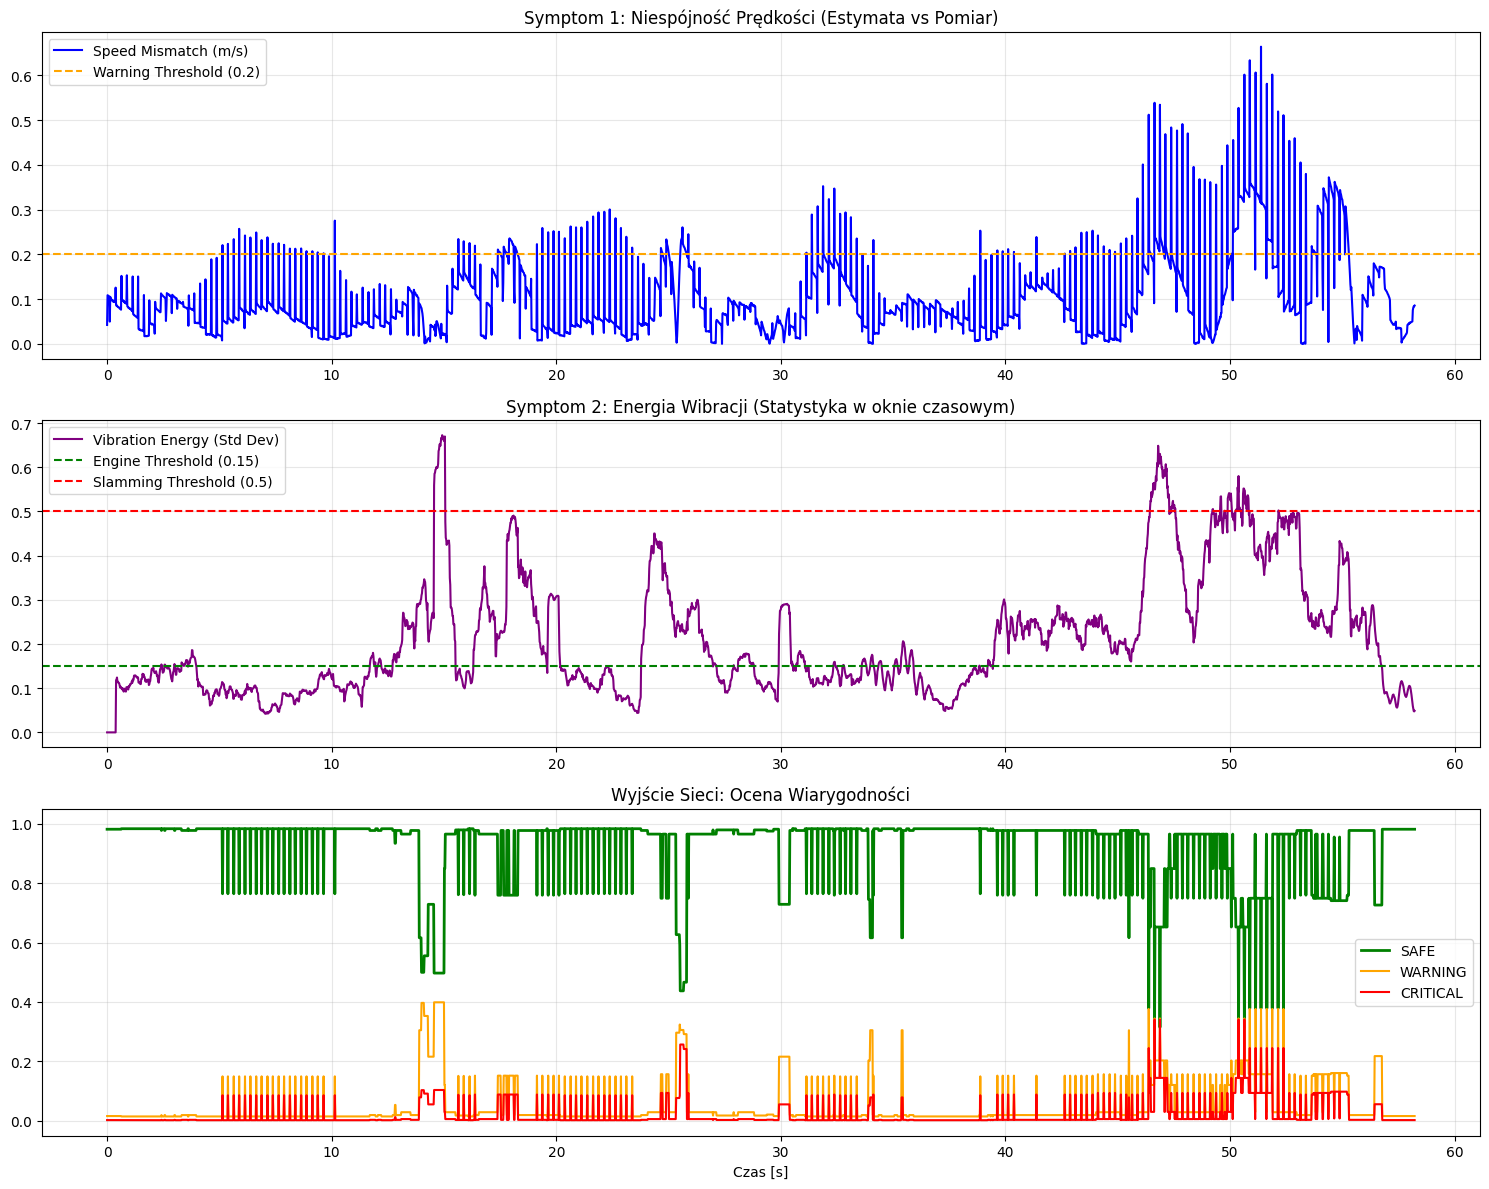

In [138]:
results_safe = []
results_warning = []
results_critical = []

for index, row in df_bn.iterrows():
    
    evidence = {
        'Mismatch_State': row['Mismatch_State'],
        'Roll_State': row['Roll_State'],
        'Vibration_State': row['Vibration_State'],
        'Turn_State': row['Turn_State'],
        'Engine_Status': row['Engine_Status']
    }
    
    try:
        q = infer.query(variables=['System_Status'], evidence=evidence, show_progress=False)
        results_safe.append(q.values[0])
        results_warning.append(q.values[1])
        results_critical.append(q.values[2])
    except:
        results_safe.append(0)
        results_warning.append(1)
        results_critical.append(0)

plt.figure(figsize=(15, 12))
time_rel = df_merged['time'] - df_merged['time'].iloc[0]


plt.subplot(3, 1, 1)
plt.plot(time_rel, df_merged['speed_mismatch'], label='Speed Mismatch (m/s)', color='blue')
plt.axhline(y=0.2, color='orange', linestyle='--', label='Warning Threshold (0.2)')
plt.title('Symptom 1: Niespójność Prędkości (Estymata vs Pomiar)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(3, 1, 2)
plt.plot(time_rel, df_merged['vibration_energy'], label='Vibration Energy (Std Dev)', color='purple')
plt.axhline(y=0.15, color='green', linestyle='--', label='Engine Threshold (0.15)')
plt.axhline(y=0.5, color='red', linestyle='--', label='Slamming Threshold (0.5)')
plt.title('Symptom 2: Energia Wibracji (Statystyka w oknie czasowym)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(3, 1, 3)
plt.plot(time_rel, results_safe, label='SAFE', color='green', linewidth=2)
plt.plot(time_rel, results_warning, label='WARNING', color='orange', linewidth=1.5)
plt.plot(time_rel, results_critical, label='CRITICAL', color='red', linewidth=1.5)
plt.title('Wyjście Sieci: Ocena Wiarygodności', fontsize=12)
plt.xlabel('Czas [s]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig('integrity_monitor_final.png')
plt.show()

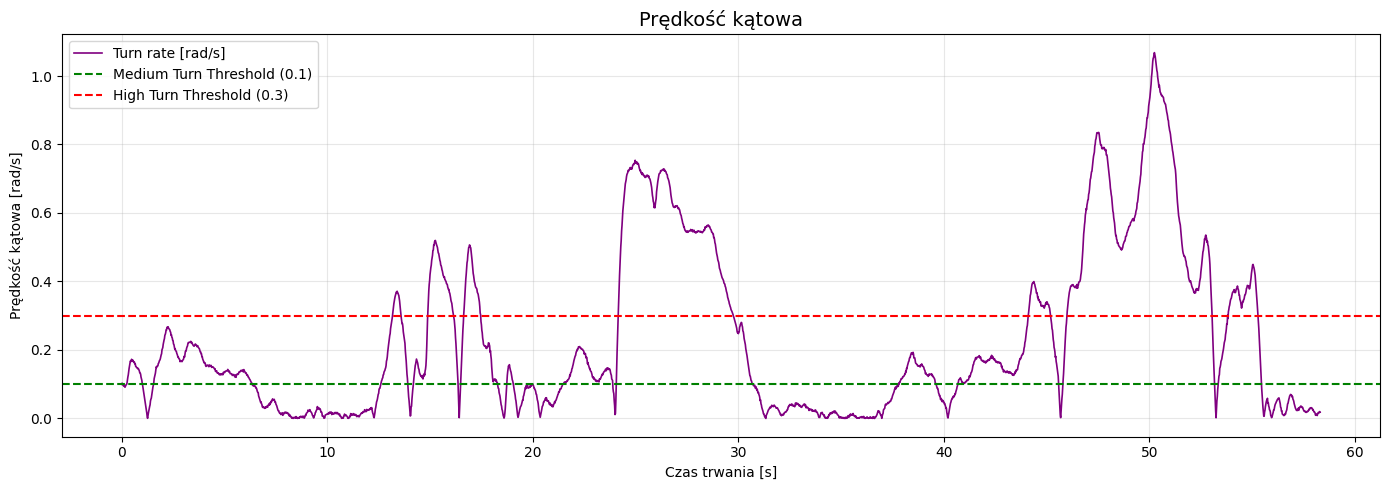

In [139]:
plt.figure(figsize=(14, 5))

time_rel = df_imu['time'] - df_imu['time'].iloc[0]

plt.plot(
    time_rel,
    df_imu['turn_rate'],
    color='purple',
    linewidth=1.2,
    label='Turn rate [rad/s]'
)

plt.axhline(y=0.1, color='green', linestyle='--', label='Medium Turn Threshold (0.1)')
plt.axhline(y=0.3, color='red', linestyle='--', label='High Turn Threshold (0.3)')

plt.title('Prędkość kątowa', fontsize=14)
plt.xlabel('Czas trwania [s]')
plt.ylabel('Prędkość kątowa [rad/s]')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

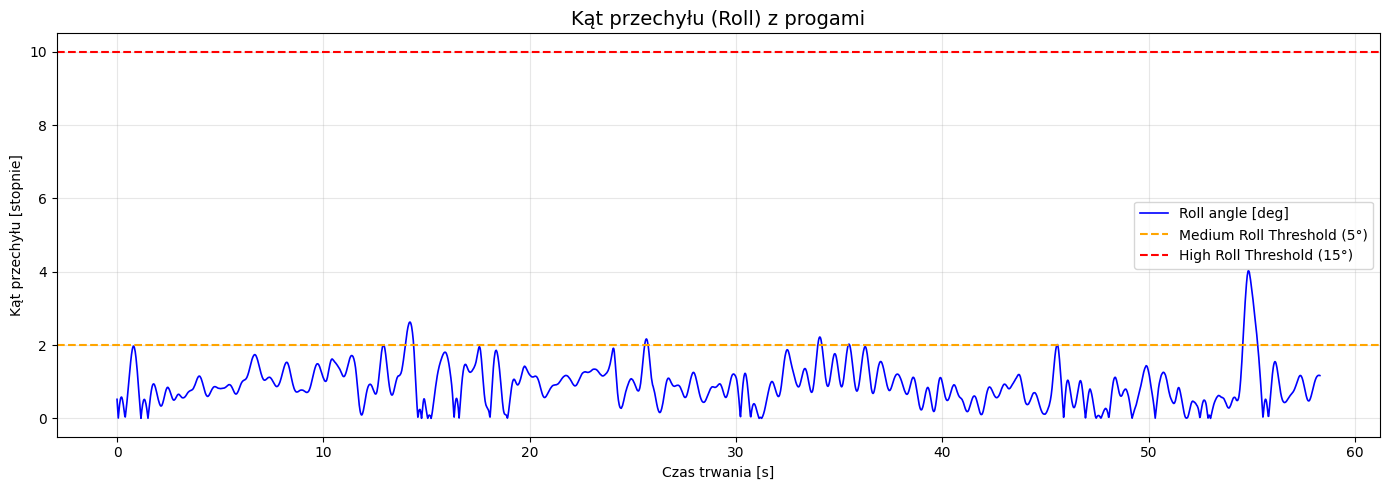

In [140]:
plt.figure(figsize=(14, 5))

plt.plot(
    time_rel,
    df_imu['roll'],
    color='blue',
    linewidth=1.2,
    label='Roll angle [deg]'
)

plt.axhline(y=2, color='orange', linestyle='--', label='Medium Roll Threshold (5°)')
plt.axhline(y=10, color='red', linestyle='--', label='High Roll Threshold (15°)')

plt.title('Kąt przechyłu (Roll) z progami', fontsize=14)
plt.xlabel('Czas trwania [s]')
plt.ylabel('Kąt przechyłu [stopnie]')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Zapis wytrenowanego modelu wnioskowania sieci bayesowskiej do pliku w celu późniejszego wykorzystania.

In [141]:
with open('integrity_network.pkl', 'wb') as f:
    pickle.dump(infer, f)